# Import packages + dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import datetime
import statistics

from dateutil.relativedelta import relativedelta
from collections import Counter

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# Read in the datasets.
df = pd.read_csv('penn_hr_data.csv')
df_month = pd.read_csv('penn_hr_monthly.csv')

C:\ProgramData\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (48,52,55,56,57,59,60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Prep an empty df that will eventually contain all features to be fed into the model.
data = pd.DataFrame(columns = ['WORKER_ID', 'SEX'])

# Data Cleaning 

### Drop certain entries

In [8]:
# Omit 15 entries that are on leave of absence.
df = df[df['EMPLOYMENT_STATUS'] != 'L']

# Omit 1 entry with invalid visa (19)
# (already dropped)

# Omit entries with negative months of service
df = df[df['MONTHS_IN_PRIMARY_JOB'] >= 0]

# Omit entries with nonsensical education level year
df = df[~df['EDUCATION_LEVEL_YEAR'].isin([1887, 2020, 2105])]

# Omit entries without salary values
df = df[-df['PRIMARY_APPT_SALARY'].isnull()]

# Omit 98 entries without birth date or original hire date
df = df[-df['ORIGINAL_HIRE_DATE'].isnull()]
df = df[-df['Birth_Date'].isnull()]

In [9]:
# Now that rows have dropped, we can update our data df
data['WORKER_ID'] = df.Worker_ID
data['MONTHS_IN_PRIMARY_JOB'] = df.MONTHS_IN_PRIMARY_JOB
data['PRIMARY_APPT_SALARY'] = df.PRIMARY_APPT_SALARY
data['IN_UNION'] = df.IN_UNION
data['SALARY_GROWTH'] = df.Career_Salary_Growth
data['PERCENT_SALARY_GROWTH'] = df.Percent_Career_Salary_Growth
data['NUM_SAL_ADJUSTMENTS'] = df.Number_of_Sal_Adjustments
data['NUM_RECLASSES'] = df.Number_of_Reclass
data['RACE_OF_COLOR'] = df['Race_OfColor']

### Monthly dataset

In [10]:
''' Our main dataset spans July 1, 2009 - June 30, 2019. '''

' Our main dataset spans July 1, 2009 - June 30, 2019. '

#### Dropping entries

In [11]:
# Comparing monthly dataset to original dfset
df.Worker_ID[-df.Worker_ID.isin(df_month.WORKER_ID)].value_counts()  
df_month.WORKER_ID[-df_month.WORKER_ID.isin(df.Worker_ID)].value_counts()

# There are 5346 workers in original dataset that are NOT in the monthly dataset.
# There are 14 workers in the monthly dataset that are NOT in the original dataset.

19382    132
13928    132
14653    132
19377    132
19380    131
19381    125
19383     72
19391     62
14689     56
8055      55
2373      50
19375     45
19372     45
11928     40
19392     34
11138     33
19384     30
14652     29
7709      27
19385     25
19386     25
19389     25
19390     11
821        9
14682      9
13831      3
Name: WORKER_ID, dtype: int64

In [12]:
# Drop workers that are not in the original dataset.
df_month = df_month[df_month.WORKER_ID.isin(df.Worker_ID)]

# Keep only employment status == A or T
df_month = df_month[df_month.EMPLOYMENT_STATUS.isin(['A', 'T'])]

### Merge original + monthly dataset

In [13]:
''' Since the monthly dataset do not have center info, let's merge the dataset. '''
# If you have same columns in diff dfs, merged df will have "col_x" and "col_y"
nonrepeated_cols = df.columns.difference(df_month.columns)

df_merged = pd.merge(df[nonrepeated_cols], df_month, left_on = 'Worker_ID', right_on = 'WORKER_ID', how = 'inner')

# Remember, we are analyzing only preventable emmployees.
df_merged = df_merged[-df_merged['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24', '3', '4', '6', '30', '31', '80', '81'])]

### Cleaning up the columns

In [14]:
text_cols = ['EDUCATION_LEVEL','COUNTRY_OF_CITIZENSHIP','HOME_CITY','VISA','JOB_GRADE','JOB_TITLE','Manager_Edu_Level',
             'EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year','REPORTS_TO_PENN_ID']

for col in text_cols:
    df[col] = df[col].fillna('')
    df[col] = df[col].apply(str).str.strip()
    
edu_cols = ['EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year']

for col in edu_cols:
    df[col] = df[col].apply(lambda x: float(x) if len(x)>0 else None)

In [15]:
# transform str to datetime object
dates_cols = ['Birth_Date','PRIMARY_APPT_BEGIN_DATE','ORIGINAL_HIRE_DATE','TERMINATION_DATE']

for col in dates_cols:
    df[col] = pd.DatetimeIndex(df[col])

### One hot encoding

In [16]:
''' Variable of interest: Employment status '''
# Convert T => 1 and A => 0
le = LabelEncoder()

df['EMPLOYMENT_STATUS'] = le.fit_transform(df['EMPLOYMENT_STATUS'])

data['EMPLOYMENT_STATUS'] = df['EMPLOYMENT_STATUS']

In [17]:
# Weekly paid = 1
df['PAY_CYCLE'] = df['PAY_CYCLE'].apply(lambda x: 0 if x == 'M1' else 1)

data['PAY_CYCLE'] = df['PAY_CYCLE']

In [18]:
# Female = 1
df['SEX'] = df['SEX'].apply(lambda x: 0 if x == 'M' else 1)

data['SEX'] = df['SEX']

In [19]:
# Create dummies for race, marital status, and grant paid
categorical_cols = ['RACE','MARITAL_STATUS','GRANT_PAID']

for col in categorical_cols:
    df1 = pd.get_dummies(df[col]).rename(lambda x: col + '_' + str(x), axis=1)
    df = pd.concat([df, df1], axis=1)

# Add to the data df
data['RACE_A'] = df['RACE_A']
data['RACE_B'] = df['RACE_B']
data['RACE_C'] = df['RACE_C']
data['RACE_P'] = df['RACE_P']
data['RACE_R'] = df['RACE_R']
data['RACE_S'] = df['RACE_S']
data['RACE_U'] = df['RACE_U']
data['RACE_Z'] = df['RACE_Z']

data['MARRIED'] = df['MARITAL_STATUS_M']
data['SINGLE'] = df['MARITAL_STATUS_S']
data['WIDOWED'] = df['MARITAL_STATUS_W']
data['DIVORCED'] = df['MARITAL_STATUS_D']

data['GRANT_PAID_F'] = df['GRANT_PAID_F']
data['GRANT_PAID_N'] = df['GRANT_PAID_N']
data['GRANT_PAID_P'] = df['GRANT_PAID_P']

# Monthly turnover rates

### Create headcount df

Separate dataset into "good" vs. "bad" hires.

In [20]:
# Non-voluntary reasons:
'''
### Bad hires
20 :  Not Qualified
21 :  Excessive Unexcused Absence or Tardiness
22 :  Unsatisfactory Performance
23 :  Misconduct or Violation of Rules
24 :  Other Termination for Cause

### Out of Penn control / concern
3 :  Lack of Funding
4 :  Completion of Contract
6 :  End of Appointment

30 :  Normal Retirement
31 :  Early Retirement

80 :  Death
81 :  Death with Benefits Eligible Dependent(s)
'''

# Voluntary reasons:
'''
33 :  Auto Termination

40 :  Accepted New Job (Academic)
41 :  Accepted New Job (Non-Academic)

42 :  Marriage or Domestic Obligations
43 :  Dissatisfied with Pay
44 :  Personal Reasons
45 :  Quit without Notice
46 :  Relocation
47 :  Returned to School
48 :  Dissatisfied with Working Conditions

60 :  Medical Necessity
'''

'\n33 :  Auto Termination\n\n40 :  Accepted New Job (Academic)\n41 :  Accepted New Job (Non-Academic)\n\n42 :  Marriage or Domestic Obligations\n43 :  Dissatisfied with Pay\n44 :  Personal Reasons\n45 :  Quit without Notice\n46 :  Relocation\n47 :  Returned to School\n48 :  Dissatisfied with Working Conditions\n\n60 :  Medical Necessity\n'

In [21]:
''' Separate bad vs. good hires '''
# Subset 'employees Penn should refrain from hiring'
df_month_bad = df_month[df_month['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24'])]

# Subset 'employees that Penn can do things for do keep' (i.e. excludes 'out of control' reasons)
df_month_good = df_month[-df_month['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24', '3', '4', '6', '30', '31', '80', '81'])]

In [22]:
# Focus analysis on "good" hires

# df for active employees
df_headcount_A = df_month_good[df_month_good.EMPLOYMENT_STATUS == 'A'].groupby(['CALENDAR_YEAR', 'CALENDAR_MONTH']).agg({'WORKER_ID': 'count'})
df_A_unstack = df_headcount_A.unstack()
df_A_unstack = df_A_unstack.fillna(0)

# df for terminated employees
df_headcount_T = df_month_good[df_month_good.EMPLOYMENT_STATUS == 'T'].groupby(['CALENDAR_YEAR', 'CALENDAR_MONTH']).agg({'WORKER_ID': 'count'})
df_T_unstack = df_headcount_T.unstack()
df_T_unstack = df_T_unstack.fillna(0)

### Calculate monthly turnover rate

In [23]:
# Vectorize no. of terminated employees
terminated = []

for year in range(2008, 2020):
    for month in range(1, 13):
        terminated.append(df_T_unstack.loc[year, ('WORKER_ID', month)])
        
terminated = terminated[6:-6]   # our data begins in July

In [24]:
# Vectorize no. of current employees
headcount = []

for year in range(2008, 2020):
    for month in range(1, 13):
        headcount.append(df_A_unstack.loc[year, ('WORKER_ID', month)])
        
headcount = headcount[5:-6]   # include one extra space to take avg(previous & current month)
headcount[0] = headcount[1]   # since the first month is unknown, let it equal July, 2008 count

In [25]:
# Find the avg no. of headcount per month
def avg(prev, current):
    return((prev + current)/2)

avg_employed = []
for i in range(0, len(headcount)-1):
    avg_count = avg(headcount[i], headcount[i+1])
    
    avg_employed.append(avg_count)

In [26]:
# Calculate the monthly turnover
turnover = [(a/b)*100 for a,b in zip(terminated, avg_employed)]

In [27]:
# Create df of these values, and export as csv.
df_ts = pd.DataFrame(columns = ['Terminated', 'Employed', 'Turnover'])

df_ts['Terminated'] = terminated
df_ts['Employed'] = headcount[1:]
df_ts['Turnover'] = turnover

df_ts.to_csv('Ts_Penn_HR.csv')

### Top 5 centers for turnover

In [28]:
center_dict = dict(zip(df['HOME_SCHOOL_CTR'], df['School_Name']))

for key in sorted(center_dict.keys()):
    print(key, ': ', center_dict[key])
    
print(len(center_dict))   # 35 centers

2 :  School of Arts and Sciences
4 :  Provost Interdisciplinary Programs
6 :  School of Nursing
7 :  Wharton School
13 :  School of Engineering and Applied Science
19 :  Annenberg Center For Performing Arts
24 :  Division of Recreation & Intercollegiate Athletics
26 :  University Museum
32 :  Graduate School of Education
33 :  School of Design
35 :  School of Social Policy and Practice
36 :  Annenberg School for Communication
40 :  Perelman School of Medicine
50 :  University Library
51 :  School of Dental Medicine
56 :  Law School
58 :  School of Veterinary Medicine
60 :  Morris Arboretum
61 :  Institute of Contemporary Art
62 :  Penn Global
78 :  Audit Compliance and Privacy
79 :  Division of Public Safety
81 :  President's Center
83 :  Provost's Center
84 :  Student Activities
85 :  Student Services
86 :  College Houses and Academic Services
87 :  Division of Finance
90 :  Development and Alumni Relations
91 :  Information Systems and Computing
92 :  Human Resources
93 :  Business S

In [29]:
# Calculate turnover (over 10 years) for all 35 centers.
center_turnover = {}

for center in center_dict.keys():
    
    # df for terminated vs. active employees
    center_headcount_T = df_merged[(df_merged.EMPLOYMENT_STATUS == 'T') & (df_merged.HOME_SCHOOL_CTR == center)].groupby(['CALENDAR_YEAR', 'CALENDAR_MONTH']).agg({'WORKER_ID': 'count'})
    center_T_unstack = center_headcount_T.unstack()
    center_T_unstack = center_T_unstack.fillna(0)
    
    center_headcount_A = df_merged[(df_merged.EMPLOYMENT_STATUS == 'A') & (df_merged.HOME_SCHOOL_CTR == center)].groupby(['CALENDAR_YEAR', 'CALENDAR_MONTH']).agg({'WORKER_ID': 'count'})
    center_A_unstack = center_headcount_A.unstack()
    center_A_unstack = center_A_unstack.fillna(0)
    
    if center_A_unstack.loc[2019, ('WORKER_ID', 6)] < 100:   # concerned only about centers with at least 100 workers
        continue
        
    if center in [24, 85]:   # these centers have several months without data
        continue
    
    # Get a headcount of active vs. terminated for each year.
    terminated = []
    active = []    
    
    for year in range(2008, 2020):
        
        # For terminated count
        if year in center_headcount_T.index.get_level_values('CALENDAR_YEAR'):
            
            for month in range(1, 13):
                if month in center_T_unstack.columns.get_level_values('CALENDAR_MONTH'):
                    terminated.append(center_T_unstack.loc[year, ('WORKER_ID', month)])
                else:
                    terminated.append(0)
            
        else:
            for month in range(1, 13):
                terminated.append(0)
        
        # For active count
        if year in center_headcount_A.index.get_level_values('CALENDAR_YEAR'):
            
            for month in range(1, 13):  
                if month in center_A_unstack.columns.get_level_values('CALENDAR_MONTH'):
                    active.append(center_A_unstack.loc[year, ('WORKER_ID', month)])
                else:
                    active.append(0)
                
        else: 
            for month in range(1, 13):
                active.append(0)
            
    
    terminated = terminated[6:-6]   # our data begins in July
    active = active[5:-6]   # include one extra space to take avg(previous & current month)
    active[0] = active[1]   # since the first month is unknown, let it equal July, 2008 count
     
    # Calculate turnover
    def avg(prev, current):
        return((prev + current)/2)

    avg_employed = []
    for i in range(0, len(active)-1):
        avg_count = avg(active[i], active[i+1])
    
        avg_employed.append(avg_count)
        
    turnover = [(a/b)*100 for a,b in zip(terminated, avg_employed)]
    turnover = statistics.mean(turnover)
    
    # Save to the dictionary
    center_turnover.update({turnover:center})

In [30]:
for key in sorted(center_turnover.keys(), reverse = True):
    print(key, ': ', center_turnover[key])
    
'''
Top 5 centers with highest turnover:

1) Development and Alumni Relations
2) Division of Recreation & Intercollegiate Athletics
3) School of Nursing
4) Perelman School of Medicine
5) School of Arts and Sciences
'''

0.8844831312335206 :  90
0.8331337452192406 :  6
0.8206152129820788 :  40
0.7845693744288824 :  2
0.6602800914280138 :  58
0.5907596638037422 :  83
0.5829871330577039 :  51
0.5213946789511531 :  81
0.5194046925022527 :  7
0.5168012722389413 :  13
0.4558165609848325 :  32
0.45400648452812625 :  93
0.40820369577065213 :  56
0.36644560632790807 :  87
0.3439147993371528 :  50
0.34378882551045414 :  91
0.31074777757198385 :  79
0.310574155544094 :  95
0.1295258936840108 :  96


'\nTop 5 centers with highest turnover:\n\n1) Development and Alumni Relations\n2) Division of Recreation & Intercollegiate Athletics\n3) School of Nursing\n4) Perelman School of Medicine\n5) School of Arts and Sciences\n'

# Feature engineering

Keep in mind: Your target variable is EMPLOYMENT_STATUS.

1 = terminated
0 = active

### Age columns

In [31]:
# Age when employee started working at Penn
df['Age_start'] = df['ORIGINAL_HIRE_DATE'] - df['Birth_Date']
df['Age_start'] = df['Age_start'].apply(lambda x: int(np.floor(x.days/365)))

# Age when employee was terminated (if active, current age)
df['Age_last'] = df['AGE_AT_TERMINATION'].fillna(df['CURRENT_AGE'])

data['AGE_START'] = df['Age_start']
data['AGE_LAST'] = df['Age_last']

###  First job at Penn

In [32]:
# 1 indicates the primary job is the employee's first job at Penn, 0 indicates otherwise
df['Is_First'] = (df['ORIGINAL_HIRE_DATE'] == df['PRIMARY_APPT_BEGIN_DATE']).astype(int)

data['FIRST_JOB_PENN'] = df['Is_First']

### From Philly

In [33]:
# Clean up all misspellings of PHILADELPHIA. 
df['HOME_CITY'] = df['HOME_CITY'].apply(lambda x: 'PHILADELPHIA' if (x == 'PHILA') or (x == 'PHILADELPIA') or 
                                            (x == 'PHILADEPHIA') or (x == 'PHILDELPHIA') or (x == 'PHILDEPHIA') else x)

# From Philly = 1
df['Local'] = df['HOME_CITY'].apply(lambda x: 1 if x == 'PHILADELPHIA' else 0)

data['FROM_PHILLY'] = df['Local']

### US citizenship

In [34]:
# US citizen = 1
df['US'] = df['COUNTRY_OF_CITIZENSHIP'].apply(lambda x: 1 if x == '' else 0)

data['US_CITIZEN'] = df['US']

### Average ratings

In [35]:
rating_map = {'E':10,'R':8,'M':6,'N':4,'U':2}

rating_df = pd.DataFrame()

for year in range(2010,2020):
    df['OVR_RATING_CD_'+str(year)] = df['OVR_RATING_CD_'+str(year)].apply(lambda x: rating_map[x] if x in rating_map else 0)
    rating_df = pd.concat([rating_df,df['OVR_RATING_CD_'+str(year)]],axis=1)
    
valid_years = np.array([10-c[0] for c in [Counter(x) for x in rating_df.values]])
total = np.array(rating_df.apply(np.sum,axis=1).values)
avg_rating = np.zeros(len(total))

for i in range(len(total)):
    
    if valid_years[i] == 0:
        avg_rating[i] = None
        
    else:
        avg_rating[i] = total[i]/valid_years[i]
        
df['avg_rating'] = pd.Series(avg_rating)

data['AVG_RATING'] = df['avg_rating']

### Employee vs. Manager columns

In [36]:
# Has_Manager indicates if a person has a manager (1)
df['Has_Manager'] = df['REPORTS_TO_PENN_ID'].apply(lambda x: 0 if len(x)==0 else 1)

# 1 if manager and employee are of different sex
df['sex_diff'] = (df["SEX"]!=df['Manager_Sex']).apply(int)
df.loc[df['Manager_Sex'].isnull(),'sex_diff'] = 0

# 1 if manager and employee are of different race
df['race_diff'] = (df["RACE"]!=df['Manager_Race']).apply(int)
df.loc[df['Manager_Race'].isnull(),'race_diff'] = 0

data['HAS_MANAGER'] = df['Has_Manager']
data['SEX_DIFF'] = df['sex_diff']
data['RACE_DIFF'] = df['race_diff']

In [37]:
# Compare employee vs. manager edu levels
edu_map = {'B':0, 'C':1,'E':2, 'D':2, 'F':3, 'G':4, 'H':5, 'K':6,'I':6, 'L':6, 'J':6}

# map NaN in education level to 1, same group as "C"
df['EDUCATION_LEVEL'] = df['EDUCATION_LEVEL'].apply(lambda x: edu_map[x] if x in edu_map else 1)

# leave NaN in nanager education as None
df['Manager_Edu_Level'] = df['Manager_Edu_Level'].apply(lambda x: edu_map[x] if x in edu_map else None)

# difference between manager and employee education levels
# if someone doesn't have a manager, or manager education df is missing, make the difference 0
df['edu_diff'] = df['Manager_Edu_Level'] - df['EDUCATION_LEVEL']
df['edu_diff'] = df['edu_diff'].fillna(0)

data['EDU_LEVEL'] = df['EDUCATION_LEVEL']
data['EDU_DIFF'] = df['edu_diff']

### Job grade columns

- Remove job grade 'PHR'<br>
- Job grades A-H are IT positions and correspond to job grades 25-32, respectively <br>
- Job grade U indicates "In_Union": mostly maintenance people (judging from their job titles); classify them as job grade 21(lowest in dataset) <br>
- Add new column IS_IT <br>  

In [38]:
job_grade = {}

# create a dict that maps A-H to 25-32
for i,j in enumerate(range(25,33)):
    job_grade[chr(ord('A')+i)] = j
    
# new column IS_IT, 1 for yes, 0 for no
x = df['JOB_GRADE'].apply(lambda x: 1 if x in job_grade else 0)
x = x.to_frame().rename(columns={'JOB_GRADE':'IS_IT'})
df = pd.concat([df, x], axis=1)

# convert letter job grades to numbers
job_grade['U'] = 21
df['JOB_GRADE'] = df['JOB_GRADE'].apply(lambda x: job_grade[x] if x in job_grade else x)

# Remove job grade = 'PHR'
df = df[df['JOB_GRADE']!='PHR']

df['JOB_GRADE'] = df['JOB_GRADE'].astype(int)

data['JOB_GRADE'] = df['JOB_GRADE']
data['HAS_IT_JOB'] = df.IS_IT

### Time till visa expires

In [39]:
# Calculate the no. of months till visa expires.
'''
Non foreigners & immigrants don't have a visa expiration date.
This means that they will be in America permanently. To differentiate them from visa-holders, assign them a value = 180.

Why 180? The longest visa is 10 years, so 15 years (= 180 months) is long enough to denote residents as permanent.
'''

"\nNon foreigners & immigrants don't have a visa expiration date.\nThis means that they will be in America permanently. To differentiate them from visa-holders, assign them a value = 180.\n\nWhy 180? The longest visa is 10 years, so 15 years (= 180 months) is long enough to denote residents as permanent.\n"

In [77]:
# Get today's datetime.
today = datetime.datetime.today()

visa_month = df['VISA_EXPIRATION_DATE'].apply(lambda x: str(x).split('/')[0])
visa_year = df['VISA_EXPIRATION_DATE'].apply(lambda x: str(x)[-9:-5]) 

visa_month = visa_month.replace('nan', 99)
visa_year = visa_year.replace('', 9999)

visa_month = visa_month.apply(lambda x: int(x))
visa_year = visa_year.apply(lambda x: int(x))


# Calculate the no. of months till visa expires.
time_left = (visa_year - today.year) * 12 + (visa_month - today.month)


# Add as a column to the df.
df['VISA_MONTHS_LEFT'] = time_left

In [78]:
# Assign 180 to all workers who don't need to worry about visas.
df.loc[df['VISA'].isin(['IM', '  ', '']), 'VISA_MONTHS_LEFT'] = 180
df.loc[df['VISA'].isnull(), 'VISA_MONTHS_LEFT'] = 180
df.VISA_MONTHS_LEFT.fillna(180)

data['VISA_MONTHS_LEFT'] = df.VISA_MONTHS_LEFT

### Change in marital status during employment

In [42]:
# Find workers who experienced a change in marital status during employment period
worker_unique = df_month.WORKER_ID.unique()

workers_marriage_changed = []

for worker in worker_unique:
    status = df_month.MARITAL_STATUS[df_month.WORKER_ID == worker]
    
    if len(status.unique()) > 1:
        workers_marriage_changed.append(worker)

In [43]:
df['MARRIAGE_CHANGED'] = np.nan

for index, value in enumerate(df.Worker_ID):
    
    if (value in workers_marriage_changed):
        df.loc[index, 'MARRIAGE_CHANGED'] = 1
        
    else:
        df.loc[index, 'MARRIAGE_CHANGED'] = 0
        
        
data['MARITAL_CHANGED'] = df['MARRIAGE_CHANGED']

### Change in educational attainment during employment

In [44]:
# Find workers who experienced a change in education level during employment period
worker_unique = df_month.WORKER_ID.unique()

workers_edu_changed = []

for worker in worker_unique:
    level = df_month.EDUCATION_LEVEL[df_month.WORKER_ID == worker]
    
    # Get rid of NaN (they are counted as a unique value)
    level = [value for value in level if pd.notnull(value)]
    level_unique = []
    
    for i in level:
        if i not in level_unique:
            level_unique.append(i)
    
    if len(level_unique) > 1:
        workers_edu_changed.append(worker)

In [45]:
df['EDU_CHANGED'] = np.nan

for index, value in enumerate(df.Worker_ID):
    
    if (value in workers_edu_changed):
        df.loc[index, 'EDU_CHANGED'] = 1
        
    else:
        df.loc[index, 'EDU_CHANGED'] = 0
        
        
data['EDU_CHANGED'] = df['EDU_CHANGED']

### Change in job title during employment

In [46]:
# Find workers who experienced a change in job title during employment period
worker_unique = df_month.WORKER_ID.unique()

workers_title_changed = []

for worker in worker_unique:
    title = df_month.JOB_GRADE[df_month.WORKER_ID == worker]
    
    if len(title.unique()) > 1:
        workers_title_changed.append(worker)

In [47]:
df['TITLE_CHANGED'] = np.nan

for index, value in enumerate(df.Worker_ID):
    
    if (value in workers_title_changed):
        df.loc[index, 'TITLE_CHANGED'] = 1
        
    else:
        df.loc[index, 'TITLE_CHANGED'] = 0
        
        
data['JOB_TITLE_CHANGED'] = df['TITLE_CHANGED']

### Inspect data

In [48]:
data.head()

,WORKER_ID,SEX,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,IN_UNION,SALARY_GROWTH,PERCENT_SALARY_GROWTH,NUM_SAL_ADJUSTMENTS,NUM_RECLASSES,RACE_OF_COLOR,EMPLOYMENT_STATUS,PAY_CYCLE,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARRIED,SINGLE,WIDOWED,DIVORCED,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,AGE_START,AGE_LAST,FIRST_JOB_PENN,FROM_PHILLY,US_CITIZEN,AVG_RATING,HAS_MANAGER,SEX_DIFF,RACE_DIFF,EDU_LEVEL,EDU_DIFF,JOB_GRADE,HAS_IT_JOB,VISA_MONTHS_LEFT,MARITAL_CHANGED,EDU_CHANGED,JOB_TITLE_CHANGED
0,1,0,32,41615.00,0,1615.00,0.0403,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,26,28.0,1,0,1,4.0,1,1,0,1,4.0,25.0,0.0,180.0,0.0,0.0,0.0
1,2,0,10,32714.00,0,6714.00,0.2582,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,23,27.0,0,1,1,7.0,1,1,0,4,0.0,25.0,0.0,180.0,0.0,0.0,1.0
2,3,0,84,62636.72,0,10636.72,0.2045,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,39,46.0,1,1,1,10.0,1,1,0,4,2.0,26.0,1.0,180.0,0.0,0.0,0.0
3,4,0,115,90815.00,0,25815.00,0.3971,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,27,52.0,0,0,1,8.0,1,1,0,4,1.0,29.0,0.0,180.0,0.0,0.0,0.0
4,5,1,4,29120.00,0,0.00,0.0000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,21,23.0,0,1,1,NaN,1,1,0,1,5.0,24.0,0.0,180.0,0.0,0.0,0.0


### Check to see which columns still have null values (and how many)

In [79]:
# Columns with null values
for i in data.columns:
    if data[i].isnull().sum() != 0:
        print(i, data[i].isnull().sum())

In [50]:
# Drop average ratings... too many null values and hard to impute.
data = data.drop(columns = ['AVG_RATING'])

In [51]:
# Fill in other null values with zeros.
data = data.fillna(0)

# Subset data

In [52]:
# Again, focus on "good" hires
data['SEPARATION_REASON'] = df['SEPARATION_REASON']

data = data.loc[-data['SEPARATION_REASON'].isin(['20', '21', '22', '23', '24', '3', '4', '6', '30', '31', '80', '81'])]
data2 = data.drop(columns = ['SEPARATION_REASON'])
data = data2

# Save a separate copy of 'data' with the worker IDs
data_pred = data

# Now, drop the worker IDs for 'data,' which is to be fed into the model for training and testing
data = data.drop(columns = 'WORKER_ID')

# Building models

### Select training data

Let's make sure that there is a comparable number of active vs. terminated employees.

In [53]:
len(data_pred[data_pred.EMPLOYMENT_STATUS == 1].WORKER_ID)   # 6823 terminated
len(data_pred[data_pred.EMPLOYMENT_STATUS == 0].WORKER_ID)   # 10371 active 

10371

Let's take a look at the length of service between overall vs. active vs. terminated

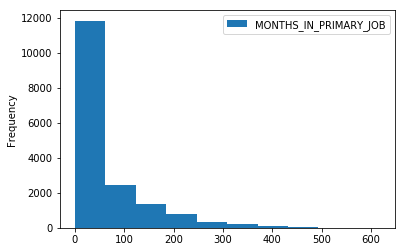

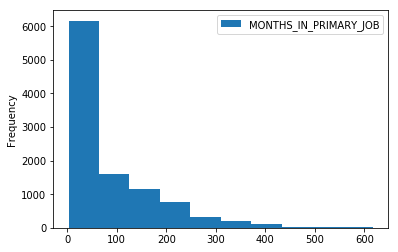

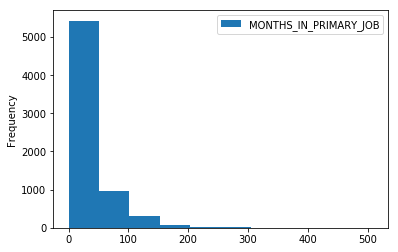

In [54]:
hist = data[['MONTHS_IN_PRIMARY_JOB']].plot.hist(bins=10)

hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS'] == 0].plot.hist(bins=10) 

hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS'] == 1].plot.hist(bins=10)

terminated within 0.0-1.0 years (<= 11.0 months): 0.2337681371830573, percentage_sum: 0.2337681371830573
terminated within 1.0-2.0 years (<= 23.0 months): 0.26439982412428553, percentage_sum: 0.4981679613073428
terminated within 2.0-3.0 years (<= 35.0 months): 0.1773413454492159, percentage_sum: 0.6755093067565587
terminated within 3.0-4.0 years (<= 47.0 months): 0.10215447750256486, percentage_sum: 0.7776637842591235
terminated within 4.0-5.0 years (<= 59.0 months): 0.061996189359519276, percentage_sum: 0.8396599736186429
terminated within 5.0-6.0 years (<= 71.0 months): 0.037959841711856956, percentage_sum: 0.8776198153304998
terminated within 6.0-7.0 years (<= 83.0 months): 0.027700425032976695, percentage_sum: 0.9053202403634765
terminated within 7.0-8.0 years (<= 95.0 months): 0.022277590502711418, percentage_sum: 0.9275978308661879
terminated within 8.0-9.0 years (<= 107.0 months): 0.01714788216327129, percentage_sum: 0.9447457130294592
terminated within 9.0-10.0 years (<= 119.0 

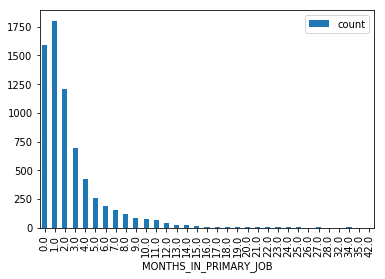

In [55]:
x = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS'] == 1].\
    groupby(by = np.floor(data['MONTHS_IN_PRIMARY_JOB']/12)).\
    count().rename(columns={'MONTHS_IN_PRIMARY_JOB':'count'})

ax = x.plot.bar(y='count')
 
for c,i in enumerate(x.index):
    per_year = x.iloc[c:(c+1)].values.sum()/x.values.sum()
    percentage = x.iloc[:(c+1)].values.sum()/x.values.sum()
    print('terminated within {}-{} years (<= {} months): {}'.format(i,i+1,12*(i+1)-1,per_year), 'percentage_sum: {}'.format(percentage),sep=', ')
    if percentage>=0.95:
        break

Plot a correlation heat map to see what features are strongly correlated with employment status.

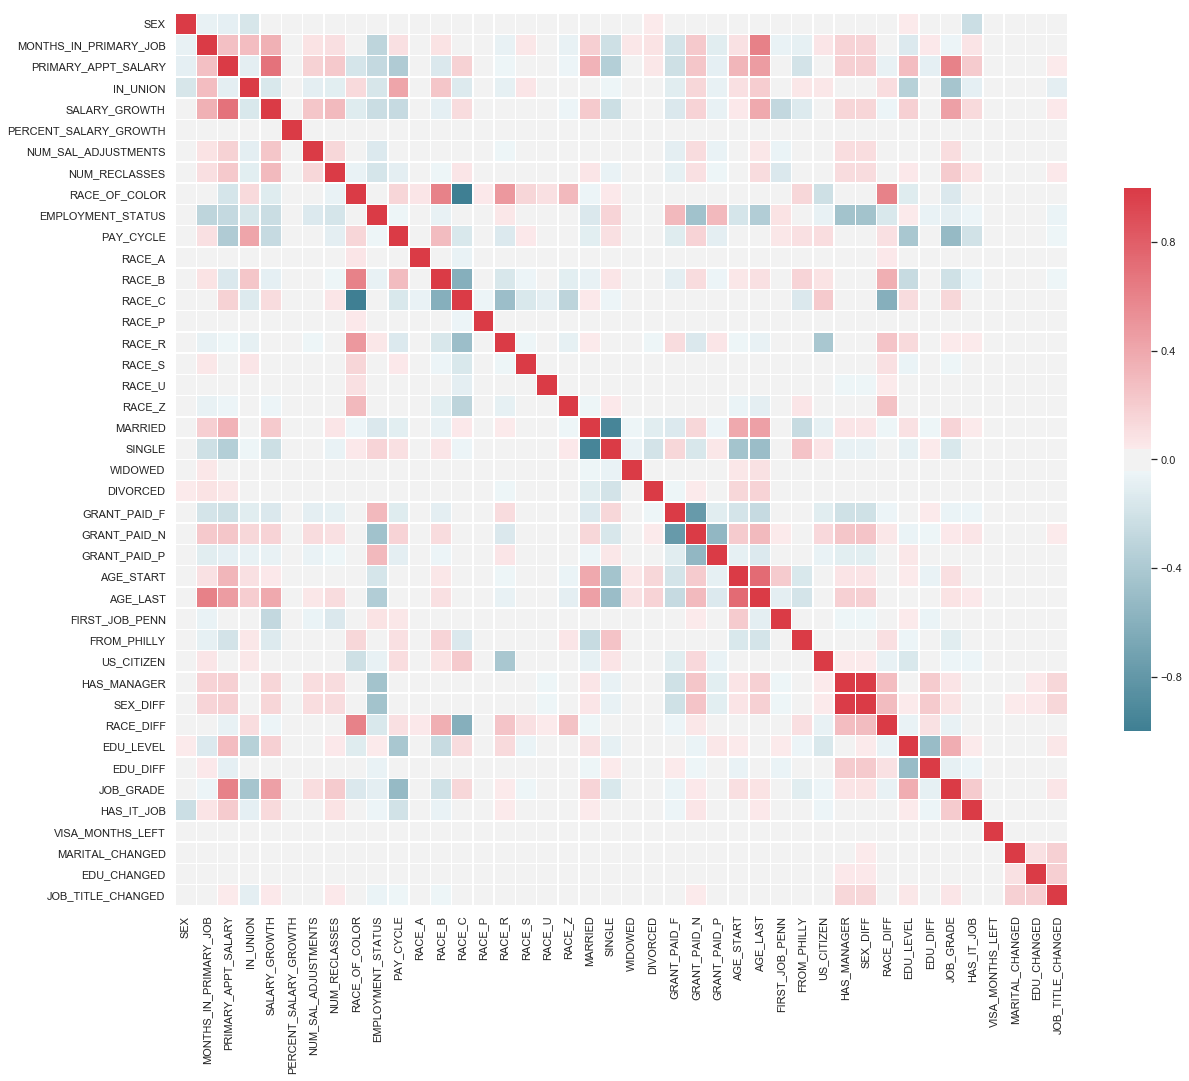

In [56]:
sns.set(style="white")

corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,  cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Split and standardize the data

In [57]:
# transform data into array
y = data[['EMPLOYMENT_STATUS']].values.reshape(-1)
X = data.drop(columns='EMPLOYMENT_STATUS')

# split into training and testing data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# save nonstandarized copies for Random Forest
x_train_nonstd = x_train
x_test_nonstd = x_test

In [58]:
binary_cols = []

for i in data.columns:
    if len(data[i].unique()) == 2:
        binary_cols.append(i)
        
nonbinary = []

for i in data.columns:
    if i not in binary_cols:
        nonbinary.append(i)

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train[nonbinary])

x_train[nonbinary] = scaler.transform(x_train[nonbinary])
x_test[nonbinary] = scaler.transform(x_test[nonbinary])

x_train = x_train.values
x_test = x_test.values

C:\ProgramData\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

### PCA

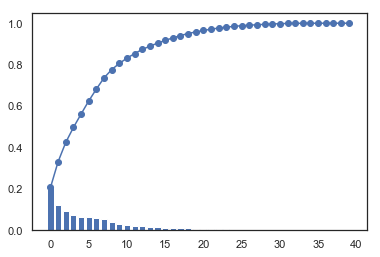

[0.207 0.331 0.425 0.496 0.561 0.625 0.682 0.736 0.776 0.806 0.831 0.853
 0.873 0.889 0.904 0.917 0.929 0.94  0.95  0.958 0.965 0.971 0.977 0.981
 0.985 0.988 0.99  0.993 0.995 0.996 0.998 0.999 0.999 1.    1.    1.
 1.    1.    1.    1.   ]
27 components explained over 99% variance


In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components = x_train.shape[1]-1, whiten=True).fit(x_train) 

ratio = pca.explained_variance_ratio_
cum_ratio = np.array([sum(ratio[0:i+1]) for i in range(len(ratio))])

plt.bar(list(range(len(ratio))),ratio)
plt.plot(cum_ratio,'-o')
plt.show()
print(np.round(cum_ratio,3))
t = 0.99
cut_off = np.where(cum_ratio>t)[0][0]+1
print('{} components explained over {}% variance'.format(cut_off, int(100*t)))

In [62]:
pca_final = PCA(n_components=cut_off).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

PCA not applicable for Random Forest. Only marginally better for the rest. 

# Train models, and compare their performance via CV

Metric used to evaluate model performance: F1 score and ROC_AUC

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100,class_weight = "balanced")
lr = LogisticRegression(solver='lbfgs',max_iter=500)
svm = SVC(gamma='auto')
xg = XGBClassifier()

models = {}
models['Logistic Regression'] = lr
models['Random Forest'] = rfc
models['SVM'] = svm
models['XGBoost'] = xg

In [64]:
from sklearn.model_selection import KFold,cross_val_score
acc_results = []
auc_results = []

names = []
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)

i = 0
for name, model in models.items():
    kfold = KFold(n_splits=10)  # 10-fold cross-validation
    if name == 'Random Forest':
        x = x_train_nonstd
    else:
        x = x_train

    cv_acc_results = cross_val_score(model, x, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = cross_val_score(model, x, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)

    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)]
    i += 1
print(df_results.sort_values(by=['ROC AUC Mean'], ascending=False))

             Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  Accuracy STD
1        Random Forest         90.87         0.64          84.27          0.85
3              XGBoost         90.73         0.79          84.01          0.73
2                  SVM         88.36         0.91          81.14          1.04
0  Logistic Regression         87.49         0.90          80.79          1.10


### Plot accuracy and ROC AUC across models

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('ROC AUC')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

# Feed test set into models

In [66]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

In [67]:
def Plot_Metrics(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)  
    
    fig, ax = plt.subplots()
    sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu" ,fmt='d', linewidths=0.25)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("roc_auc_score:",roc_auc_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("f1_score:",f1_score(y_test, y_pred))
    
    
def plot_roc(model, x_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Logistic Regression

In [ ]:
lr = LogisticRegression(solver='lbfgs',max_iter=500).fit(x_train, y_train)
y_pred = lr.predict(x_test)

Plot_Metrics(y_test, y_pred)

In [ ]:
plot_roc(lr, x_test, y_test)

### Random Forest & Feature Importance

Accuracy: 0.8478387284357434
roc_auc_score: 0.8262292283533954
Precision: 0.8806413301662708
Recall: 0.7174649250120948
f1_score: 0.7907224740069314


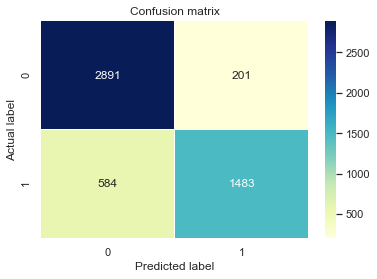

In [68]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(x_train_nonstd, y_train)

y_pred = rfc.predict(x_test_nonstd)
Plot_Metrics(y_test, y_pred)

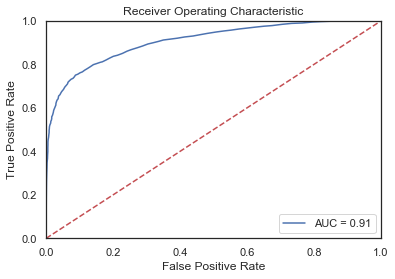

In [69]:
plot_roc(rfc, x_test_nonstd, y_test)

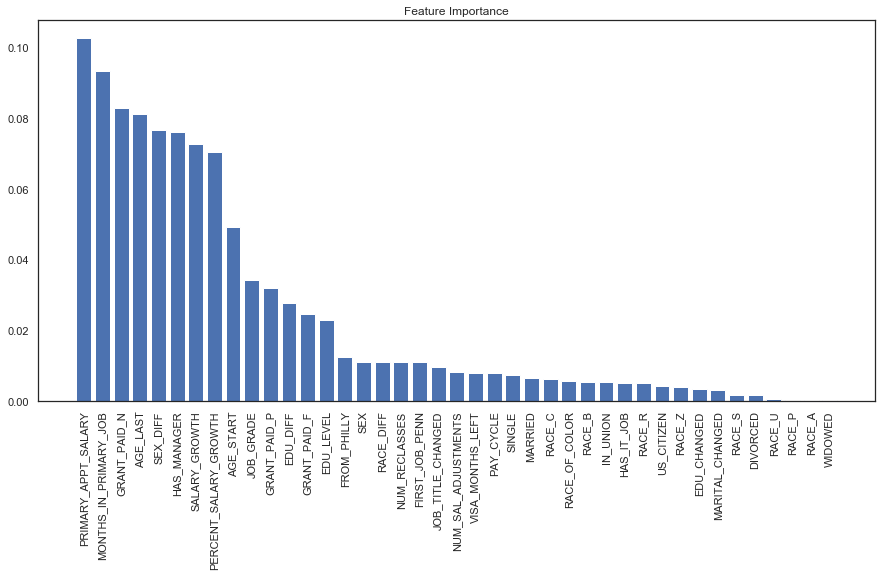

In [70]:
f = sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), data.drop(columns='EMPLOYMENT_STATUS').columns), 
             reverse=True)
plt.figure(figsize=(15, 7))
plt.title("Feature Importance") 
plt.bar(range(len(f)), [x[0] for x in f]) 
plt.xticks(range(len(f)), [x[1] for x in f], rotation=90) 
plt.show() 

### SVM

In [ ]:
svm = SVC(gamma='auto')
svm.fit(x_train, y_train) 
y_pred = svm.predict(x_test)
Plot_Metrics(y_test, y_pred)

### XGBoost

In [ ]:
xg = XGBClassifier()
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)

Plot_Metrics(y_test, y_pred)

In [ ]:
plot_roc(xg, x_test, y_test)

# Fine-tuning

Optimize hyperparameters to improve performance.

In [392]:
from sklearn.model_selection import GridSearchCV

### Random Forest

In [519]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [75, 100, 125, 150, 175, 200],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4]}

grid = GridSearchCV(rf, param_grid = param_grid, scoring = 'f1', cv=10)

g = grid.fit(x_train_nonstd, y_train)


In [520]:
rf_opt = g.best_estimator_
print("best params: " + str(g.best_estimator_))
print("best params: " + str(g.best_params_))
print('best score:', g.best_score_)

best params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=175, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best params: {'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 175}
best score: 0.7814980043230182


Accuracy: 0.8466757123473542
roc_auc_score: 0.8225614987430568
Precision: 0.8735562310030395
Recall: 0.7113861386138614
f1_score: 0.7841746248294679


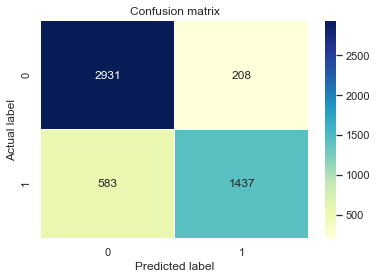

In [550]:
y_pred = rf_opt.predict(x_test_nonstd)
Plot_Metrics(y_test,y_pred)

'''
Notice: Fine tuning did NOT improve the F1 score for RFC. This is probably due to the limited parameter grid.
If permitted more time, one should consider expanding the parameter grid to find better hyperparameters.
'''

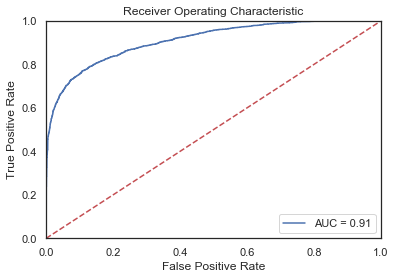

In [551]:
plot_roc(rf_opt, x_test_nonstd, y_test)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D580C6DE80>]],
      dtype=object)

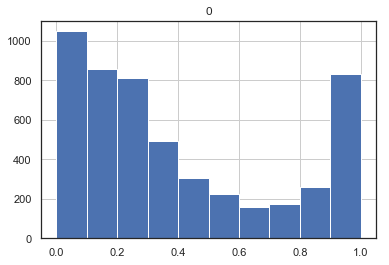

In [541]:
pd.DataFrame(probs[:,1]).hist()

### Logistic Regression

In [ ]:
param_grid = {'C': np.arange(1e-03, 2, 0.01)} # hyper-parameter list to fine-tune
grid = GridSearchCV(LogisticRegression(solver='lbfgs',max_iter=500),
                      iid=True,
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

l = grid.fit(x_train, y_train)

In [ ]:
lr_opt = l.best_estimator_
results = l.cv_results_

print("best params: " + str(l.best_estimator_))
print("best params: " + str(l.best_params_))
print('best score:', l.best_score_)

In [ ]:
# lr_opt.fit(x_train_standardized, y_train)
y_pred = lr_opt.predict(x_test)
Plot_Metrics(y_test,y_pred)

In [ ]:
lr_opt.fit(x_train, y_train) 
probs = lr_opt.predict_proba(x_test) 
# only keep probabilities associated with the employee leaving
a = roc_auc_score(y_test, probs[:, 1]) 
print('AUC score: {}'.format(round(a,3)))

# Final model

The winner is Random Forest Classifier (without fine tuned hyperparameters).

### Obtain probability of leaving for active employees

In [71]:
# Recall: data_pred is the same df as 'data,' except with worker IDs
# Extract only active employees
active_data = data_pred[data_pred.EMPLOYMENT_STATUS == 0]

# Save another copy of the df, without the worker IDs and employment status (to be fed into the model)
x_pred = active_data.drop(columns = ['WORKER_ID', 'EMPLOYMENT_STATUS'])

In [72]:
y_pred = rfc.predict(x_pred)
probs = rfc.predict_proba(x_pred)[:,1]   # probability of leaving

active_data['HIGH_RISK'] = y_pred
active_data['PROBABILITY'] = probs

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Identify "high risk" employees 

There are 49 "high risk" employees. Their probability of leaving is greater than 0.5.

In [75]:
high_risk_data = active_data[active_data.HIGH_RISK == 1]
high_risk_data

,WORKER_ID,SEX,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,IN_UNION,SALARY_GROWTH,PERCENT_SALARY_GROWTH,NUM_SAL_ADJUSTMENTS,NUM_RECLASSES,RACE_OF_COLOR,EMPLOYMENT_STATUS,PAY_CYCLE,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARRIED,SINGLE,WIDOWED,DIVORCED,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,AGE_START,AGE_LAST,FIRST_JOB_PENN,FROM_PHILLY,US_CITIZEN,HAS_MANAGER,SEX_DIFF,RACE_DIFF,EDU_LEVEL,EDU_DIFF,JOB_GRADE,HAS_IT_JOB,VISA_MONTHS_LEFT,MARITAL_CHANGED,EDU_CHANGED,JOB_TITLE_CHANGED,HIGH_RISK,PROBABILITY
3066,3067,1,66,55165.50,0,10165.50,0.2259,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,35,41.0,1,1,1,1,1,0,5,0.0,26.0,0.0,180.0,0.0,0.0,1.0,1,0.53
3263,3264,0,4,46280.00,0,0.00,0.0000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,29,31.0,0,0,1,1,1,1,2,0.0,24.0,0.0,180.0,0.0,0.0,0.0,1,0.53
4052,4053,1,28,68500.00,0,26500.00,0.6309,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,38,43.0,0,0,0,1,1,1,1,5.0,28.0,0.0,180.0,0.0,0.0,0.0,1,0.57
4079,4080,1,121,82773.00,0,49773.00,1.5082,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,39,59.0,0,1,1,1,1,1,3,3.0,27.0,0.0,180.0,0.0,0.0,0.0,1,0.51
4404,4405,0,207,122316.00,0,83316.00,2.1363,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,28,45.0,1,0,0,1,1,1,5,1.0,29.0,1.0,180.0,0.0,0.0,0.0,1,0.60
4434,4435,1,25,39270.00,0,770.00,0.0200,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,23,25.0,1,1,0,1,1,1,4,0.0,25.0,0.0,4.0,0.0,0.0,0.0,1,0.52
5389,5390,1,4,46000.00,0,0.00,0.0000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,25,25.0,1,0,1,1,1,1,4,0.0,25.0,0.0,180.0,0.0,0.0,0.0,1,0.54
5515,5516,1,40,48000.00,0,9520.00,0.2474,1,2,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,23,30.0,0,0,1,1,1,1,4,2.0,26.0,0.0,180.0,0.0,0.0,0.0,1,0.51
5984,5985,0,16,32000.00,0,-1000.00,-0.0303,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,18,22.0,0,1,1,1,1,1,4,0.0,24.0,0.0,180.0,0.0,0.0,0.0,1,0.59
6010,6011,1,25,51250.00,0,1250.00,0.0250,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,58,60.0,1,0,1,1,1,1,1,5.0,26.0,0.0,180.0,0.0,0.0,0.0,1,0.51
